## Imports

In [378]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay, precision_recall_curve,
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb

from scipy.stats import randint, uniform

### Read Data

In [273]:
raw_data = pd.read_csv('data2/car_insurance_claim.csv')

In [274]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


### Data Cleaning

In [275]:
# Create new copy of data
data_df = raw_data.copy()

First we will rename the columns.

In [276]:
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [277]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

#### Check for duplicated and null values

In [278]:
# Check number of duplicate records
data_df.duplicated().sum()

1

In [279]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

#### Format columns with a currency unit
The currency based columns include values with '$' and ','. We need to remove these characters and convert the values to integers.

In [280]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

#### Clean errors
Many records across multiple features include a 'z_' prefix. This must be removed.

In [281]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

#### Drop unuseful features
* ID is just a unique identifier so is not needed
* data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [282]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [283]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


#### Create Test Set
Our best option here would be to use stratified sampling to create our test set to prevent bias. We can do this by creating bins (strata) based on the 'new_claim_value' amount, as non-zero values here imply 'is_claim' is 1 (true) anyway. We can double check this before doing out stratified sampling:

In [284]:
# Check there are no non-zero values for 'new_claim_value' where 'is_claim' = 1
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


Good, so we can see when 'new_claim_value' is greater than 0, 'is_claim' is always 1, which is what we would expect.

Let's now see the distribution for claim values to help define the number of bins we should use:

<Axes: xlabel='new_claim_value', ylabel='Count'>

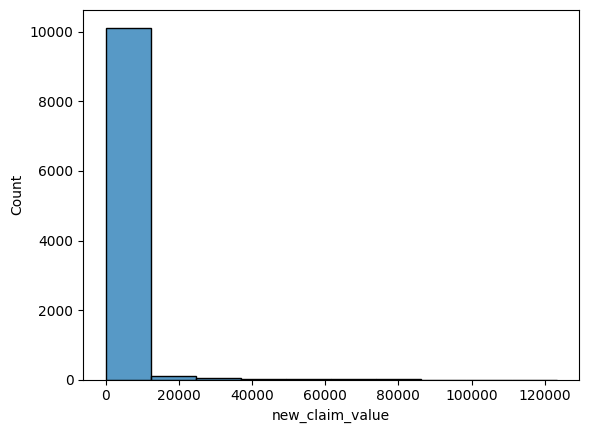

In [285]:
sns.histplot(data_df['new_claim_value'], bins=10)

We can see the feature is heavily skewed right. It would likely be best to use non-linearly spaced bins to capture the more extreme values with few instances.

In [286]:
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
labels = np.arange(1, 12)

data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

In [287]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type,claim_value_cat
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban,1
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban,1
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban,1
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban,1
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban,1


<Axes: ylabel='claim_value_cat'>

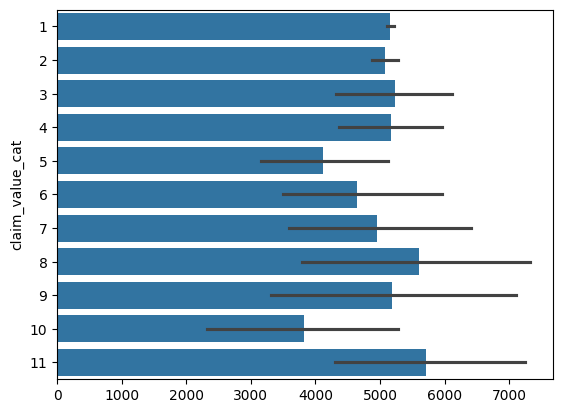

In [288]:
sns.barplot(data_df['claim_value_cat'])

The distribution looks ok for now, so we'll proceed with creating the split.

In [289]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

We can quickly compare the distibution of positive/negative class for 'is_claim' in the y_train and y_test classes:

In [290]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.48%
Test positive class ratio: 27.37%


We now need to drop the claim_value_cat feature from our X sets:

In [291]:
for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)

## Exploratory Data Analysis (EDA)

For the purpose of our EDA, we'll join X_train and y_train so we can investigate correlation.

In [292]:
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [293]:
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,No,0,No,F,<High School,Blue Collar,40,Private,7200,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,No,109835,Yes,F,<High School,Blue Collar,24,Private,6530,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,Yes,174139,No,M,<High School,Clerical,39,Private,1500,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,Yes,202178,No,F,Bachelors,Professional,18,Private,22260,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,No,312887,Yes,M,High School,Professional,25,Commercial,5400,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban,0


For the purpose of the exploration, we will first update 'Yes/No' features to '1/0' so we can see how these correlate too. We'll also update gender to use binary values. 1 = male, 0 = female

In [294]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [295]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


#### Correlation Matrix
As there are many features, we'll create a correlation matrix from just the is_claim target feature.

<Axes: >

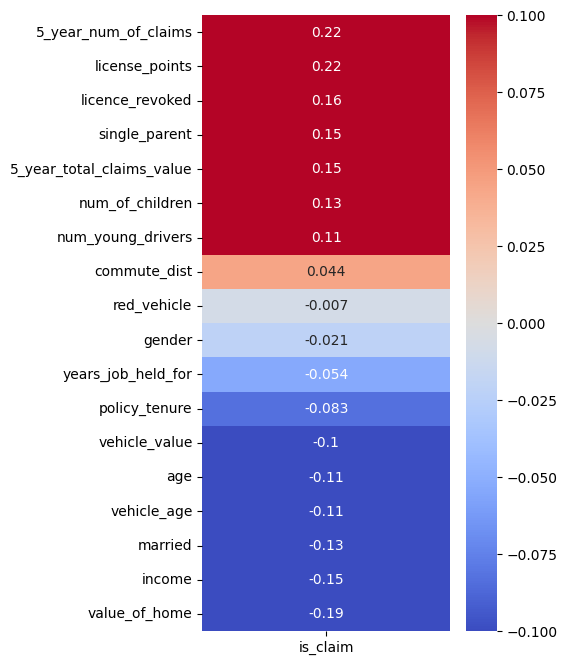

In [296]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.1, vmin=-0.1)

Obervations:

Note, we are not assuming causation, only speculating at possible reasons for correlation.

* Some of the features show much stronger positive correlation than others - these are perhaps the most expected, including:
    * 5_year_num_of_claims: Having made claims previously would suggest they are more likely to make claims in the future
    * license_points: Having points on your license may suggest your driving quality is poor, and make you more likely to be involved in an accident
    * license_revoked: Having your license revoked suggests several minor or a serious driving related offense, perhaps reflecting your driving quality
* Stronger negative correlations:
    * Home value
* Features with negligable correlation:
    * Commute distance, red vehicle and gender show very weak correlations, so it may be beneficial to remove these to reduce the number of features passed to the models

#### Handling Missing Values
Let's inspect how many missing values there are in the test data:

In [346]:
X_train_raw = X_train.copy()

In [347]:
# Check the number of missing values in each row
X_train_raw.isnull().sum().sum()

2418

In [348]:
# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

num_young_drivers              0
age                            5
num_of_children                0
years_job_held_for           433
income                       474
single_parent                  0
value_of_home                462
married                        0
gender                         0
highest_education              0
occupation                   527
commute_dist                   0
type_of_use                    0
vehicle_value                  0
policy_tenure                  0
vehicle_type                   0
red_vehicle                    0
5_year_total_claims_value      0
5_year_num_of_claims           0
licence_revoked                0
license_points                 0
vehicle_age                  517
address_type                   0
dtype: int64

There is a fairly significant number of missing values. We will need to deal with these when developing the data pipeline. As there are quite a lot of missing values, and many of which are numerical, simple imputation like median or mean may be too naive. Instead, let's impute using KNN for more advanced imputation.

In [349]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [350]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

We can now check some of the records that had missing data, and the subsequent imputations:

In [301]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
0,0,57.0,0,NaN,33707,0,0,0,0,40,7200,10,0,0,0,0,1,1.0,0
11,0,36.0,2,13.0,19934,1,<NA>,0,1,17,10790,6,1,7797,2,0,9,1.0,0
19,0,59.0,0,11.0,123969,0,347418,1,1,35,31540,1,0,0,0,0,1,NaN,0
25,0,51.0,0,7.0,141546,0,351285,0,1,18,29330,4,1,1184,2,0,4,NaN,1
28,1,51.0,1,8.0,<NA>,0,253662,1,1,5,12430,1,1,9000,1,0,0,11.0,1


In [302]:
# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
0,0.0,57.0,0.0,0.0,33707.0,0.0,0.0,0.0,0.0,40.0,7200.0,10.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
11,0.0,36.0,2.0,13.0,19934.0,1.0,158778.5,0.0,1.0,17.0,10790.0,6.0,1.0,7797.0,2.0,0.0,9.0,1.0,0.0
19,0.0,59.0,0.0,11.0,123969.0,0.0,347418.0,1.0,1.0,35.0,31540.0,1.0,0.0,0.0,0.0,0.0,1.0,8.5,0.0
25,0.0,51.0,0.0,7.0,141546.0,0.0,351285.0,0.0,1.0,18.0,29330.0,4.0,1.0,1184.0,2.0,0.0,4.0,7.0,1.0
28,1.0,51.0,1.0,8.0,67333.0,0.0,253662.0,1.0,1.0,5.0,12430.0,1.0,1.0,9000.0,1.0,0.0,0.0,11.0,1.0


In [303]:
num_test_data_imputed

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
0,0.0,57.0,0.0,0.0,33707.0,0.0,0.0,0.0,0.0,40.0,7200.0,10.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,0.0,109835.0,1.0,0.0,24.0,6530.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,1.0,174139.0,0.0,1.0,39.0,1500.0,4.0,0.0,5419.0,1.0,0.0,5.0,6.0,1.0
3,0.0,46.0,1.0,13.0,62886.0,1.0,202178.0,0.0,0.0,18.0,22260.0,1.0,0.0,5290.0,1.0,0.0,6.0,6.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,0.0,312887.0,1.0,1.0,25.0,5400.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8235,0.0,38.0,2.0,14.0,54064.0,0.0,201418.0,1.0,0.0,7.0,12220.0,7.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0
8236,0.0,38.0,0.0,10.0,22746.0,0.0,192479.0,1.0,0.0,5.0,26300.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
8237,0.0,48.0,0.0,15.0,38939.0,0.0,155006.0,0.0,1.0,28.0,31970.0,4.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0
8238,0.0,29.0,2.0,13.0,26413.0,0.0,172043.0,1.0,0.0,29.0,16200.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


We can see the values have been imputed were we had missing values.

For categorical value imputation, we'll use a simple imputer with 'most_frequent' as the strategy.

In [351]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

As before, we can now check before and after imputation for some rows with missing values:

In [352]:
# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,red_vehicle,licence_revoked,address_type
0,No,No,F,<High School,Blue Collar,Private,SUV,no,No,Highly Rural/ Rural
11,Yes,No,M,High School,Clerical,Private,Pickup,yes,No,Highly Urban/ Urban
19,No,Yes,M,Masters,NaN,Commercial,Panel Truck,no,No,Highly Urban/ Urban
25,No,No,M,PhD,Manager,Commercial,Panel Truck,yes,No,Highly Urban/ Urban
28,No,Yes,M,High School,Blue Collar,Commercial,Minivan,yes,No,Highly Urban/ Urban


In [306]:
# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,highest_education,occupation,type_of_use,vehicle_type,address_type
0,<High School,Blue Collar,Private,SUV,Highly Rural/ Rural
11,High School,Clerical,Private,Pickup,Highly Urban/ Urban
19,Masters,Blue Collar,Commercial,Panel Truck,Highly Urban/ Urban
25,PhD,Manager,Commercial,Panel Truck,Highly Urban/ Urban
28,High School,Blue Collar,Commercial,Minivan,Highly Urban/ Urban


We can now join the numerical and categorical data following imputation, to create the complete DataFrame.

In [308]:
# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim,highest_education,occupation,type_of_use,vehicle_type,address_type
0,0.0,57.0,0.0,0.0,33707.0,0.0,0.0,0.0,0.0,40.0,7200.0,10.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,<High School,Blue Collar,Private,SUV,Highly Rural/ Rural
1,2.0,41.0,3.0,14.0,17321.0,0.0,109835.0,1.0,0.0,24.0,6530.0,4.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,<High School,Blue Collar,Private,Sports Car,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,1.0,174139.0,0.0,1.0,39.0,1500.0,4.0,0.0,5419.0,1.0,0.0,5.0,6.0,1.0,<High School,Clerical,Private,Minivan,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,1.0,202178.0,0.0,0.0,18.0,22260.0,1.0,0.0,5290.0,1.0,0.0,6.0,6.0,0.0,Bachelors,Professional,Private,Minivan,Highly Urban/ Urban
4,0.0,39.0,0.0,8.0,115182.0,0.0,312887.0,1.0,1.0,25.0,5400.0,1.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,High School,Professional,Commercial,Pickup,Highly Urban/ Urban


We can now check again for missing values:

In [309]:
train_imputed_df.isnull().sum()

num_young_drivers            0
age                          0
num_of_children              0
years_job_held_for           0
income                       0
single_parent                0
value_of_home                0
married                      0
gender                       0
commute_dist                 0
vehicle_value                0
policy_tenure                0
red_vehicle                  0
5_year_total_claims_value    0
5_year_num_of_claims         0
licence_revoked              0
license_points               0
vehicle_age                  0
is_claim                     0
highest_education            0
occupation                   0
type_of_use                  0
vehicle_type                 0
address_type                 0
dtype: int64

We can see we now have no missing values in any of the features.

### Categorical Feature Encoding
We now need to consider how we will encode the categorical features so that they can be used with machine learning algorithms. Let's start by looking at the number of unqiue values each categorical feature has, so we can decide the best encoding method for each.

#### Occupation

In [353]:
cat_test_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
vehicle_type         6
red_vehicle          2
licence_revoked      2
address_type         2
dtype: int64

* Single parent has only 2 values, so we can use binary encoding for this feature.
* Married has only 2 values, so we can use binary encoding for this feature.
* Gender has only 2 values, so we can use binary encoding for this feature.
* Highest education has 5 unique values, and these have a rank/order (the level of education). We can use ordinal encoding for this feature.
* For occupation, we have 8 differnet values with no ranking or order. We can use one-hot encoding for this feature.
* Type of use has only 2 values, so we can use binary encoding for this feature.
* Vehicle type has 6 different values with no ranking or order. We can use one-hot encoding for this feature.
* Red vehicle has only 2 values, so we can use binary encoding for this feature.
* License revoked has only 2 values, so we can use binary encoding for this feature.
* Address type has only 2 values, so again, we can use binary encoding for this feature.

Since Scikit-Learn has no binary encoding option currently for independent features, we can use the ordinal encoder in this as we only have 2 unique values. We can now define which features will use which encoders:

In [387]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'red_vehicle', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

We can now create the encoders for each feature type. For the education encoder we will first need to define the order/ranking of the levels of education.

In [361]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

We can now encode the values use fit_transform:

In [369]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(X_train_raw[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(X_train_raw[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(X_train_raw[cat_cols_one_hot])

We can now return these values to a DataFrame to check the encoding:

In [379]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = X_train_raw[cat_cols_ord].columns

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = X_train_raw[cat_cols_bin].columns

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,red_vehicle,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,occupation_nan,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We can now join our encoded features back with the numerical features to give us our pre-processed data.

In [383]:
# Join numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [384]:
# Check df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,red_vehicle,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,occupation_nan,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,41.0,3.0,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,39.0,0.0,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Since we've used one-hot encoding for some of the features, we will almost certainly have issues with the 'dummy variable trap'. This occurs when one of the dummy variables is redudant, and introduces perfect multicollinearity. In simple terms, knowing the values of all feature values - 1 allows you to perfectly predict the last one. We can check the presence of multicolinearity using the variance inflation factor, or VIF:

In [386]:
# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.318900
2,age,1.471822
3,num_of_children,2.083585
4,years_job_held_for,1.437590
5,income,2.654492
6,value_of_home,2.123372
7,commute_dist,1.040762
8,vehicle_value,2.033415
9,policy_tenure,1.005914


We can clearly see the features that were one-hot encoded (occupation and vehicle type) show perfect multicolinearity. The easiest way to deal with this is to drop one of the dummy variables from the encoded data. This is often referred to as dropping the 'reference category' or 'baseline' category. We'll drop the last value from each.

In [ ]:
X_train_cleaned.drop(['occupation_' ,'vehicle_type_Van'])